In [81]:
import galois
from galois import FieldArray
import matplotlib.pyplot as plt
import numpy as np

In [82]:
####### CONSTANTS #######

# The range of the point function
# In this case we can input any number from 0 to 127 into the point function
# This corresponds to the number of elements that could be stored in this data store
DOMAIN_SIZE = 128 # |x| = 128

# The value stored at each storage slot (x) can be in the range (0, 127)
BITS = 8
GF = galois.GF(2**BITS) # |y| = 2^8 = 256

In [83]:
def Gen_0(x: int, y: int):
    # Generate a random key for k0
    k0 = GF.Random(DOMAIN_SIZE)
    k1 = k0.copy()
    
    # Generate the specified point
    k1[x] = k1[x] - GF(y)
    
    return (k0, k1)

# |y| has been excluded from the inputs as we assume that it is known
def Eval_0(k: FieldArray, x: int): 
    return k[x]

<BarContainer object of 128 artists>

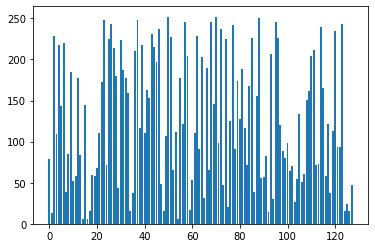

In [84]:
# Generate keys for the point P(5) = 45
k0, k1 = Gen_0(x=5, y=45)

# Observe that the point function key looks random    
plt.bar(np.arange(DOMAIN_SIZE), k0)

In [85]:
# Eval is to be done separately by each party (no communication of eval should be done between parties)
# We will evaluate the function at x=5 (the point), this should yield y=45
eval0 = Eval_0(k=k1, x=5)
eval1 = Eval_0(k=k0, x=5)

# Taking the XOR of the two evaluations will reveal the value of the function at x=3
assert eval0 ^ eval1 == 45


# We will evaluate the function at x=10 (not the point), this should yield 0
eval0 = Eval_0(k=k1, x=10)
eval1 = Eval_0(k=k0, x=10)

assert eval0 ^ eval1 == 0

## Private Information Retrieval (PIR): Read Value from "Database"

In [86]:
# We are going to assume our fake database is a list of 128 integers starting from 0 
database = GF(np.arange(DOMAIN_SIZE))

# i.e. database[n] = n
assert database[5] == 5
assert database[10] == 10

database

GF([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
     14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
     28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
     42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
     56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
     70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
     84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
     98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
    112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
    126, 127], order=2^8)

In [106]:
# We are requesting the value of the database at index 8
k0, k1 = Gen_0(x=8, y=1)

# We will construct a private query function that will return the value stored at the specified index
# This function will be evaluated by each party separately 
eval0, eval1 = GF(0), GF(0)
for i in range(len(database)):
    eval0 += Eval_0(k=k1, x=i) * database[i] # will cancel with other eval for all i apart from 8
    eval1 += Eval_0(k=k0, x=i) * database[i]


# We combine the inputs to reveal the value stored at index 8 by summing the finite field elements
# This is the same as taking the XOR of the two evaluations
assert eval0 + eval1 == 8